# Lab 01 - Techniques for Handling Large Datasets in Classification

In this scenario we will explore several techniques for handling large datasets in classification tasks. We will compare the performance of different approaches, including:

- processing the full dataset in parts
- sampling techniques
- summarization techniques
- quantization techniques

## 1. The Dataset

During this lab, we will use the [NYC Yellow Taxi Trip Data](https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data) from Kaggle.
In fact, this is a subset of the much larger and continuously updated dataset available from the [NYC Taxi & Limousine Commission (TLC)](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). The original dataset is evolving over time, with respect to its schema, therefore to avoid issues, we will use a preprocessed version from a Kaggle user.

Get familiar with the dataset page, read the description, check available columns, as well as their types and meaning. Download all available CSV files - use any means you prefer (Kaggle API, kagglehub package, direct download using browser, etc.).

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'nyc-yellow-taxi-trip-data' dataset.
Path to dataset files: /kaggle/input/nyc-yellow-taxi-trip-data


In [2]:
import pandas as pd

taxi = pd.read_csv(path + "/yellow_tripdata_2015-01.csv")
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [3]:
import numpy as np
import matplotlib.pyplot as plt

## 2. Investigate the Dataset

Get familiar with the dataset. Check the sizeof the files, the number of rows and columns, the actual data types, etc. You can use a tool of your choice (pandas, dask, pyspark, pyarrow, etc.) - the one you can install and run locally or an online tool it supports large files. Is it possible to load the entire dataset in memory? Even if it is possible in your case, try to think about scenarios where there is not enough memory available. Consequently, you should design your solutions so that they do not require loading the entire dataset at once.

In [4]:
print("Raw:", len(taxi))
mask = (
    (taxi["tpep_pickup_datetime"] <= taxi["tpep_dropoff_datetime"]) &
    (taxi["trip_distance"] > 0) &
    (taxi["fare_amount"] >= 2.5) & # min fare in NYC
    (taxi["passenger_count"].between(1, 12)) &
    taxi["pickup_latitude"].between(40.0, 41.5) & # NYC & boroughs & airports
    taxi["pickup_longitude"].between(-75.0, -72.0) &
    taxi["dropoff_latitude"].between(40.0, 41.5) & # NYC & boroughs & airports
    taxi["dropoff_longitude"].between(-75.0, -72.0)
)
clean_taxi = taxi[mask].copy()
print("After removing nonsensical data:", len(clean_taxi))

Raw: 12748986
After removing nonsensical data: 12424322


In [5]:
import gc

In [6]:
del taxi  # free up memory

gc.collect()

0

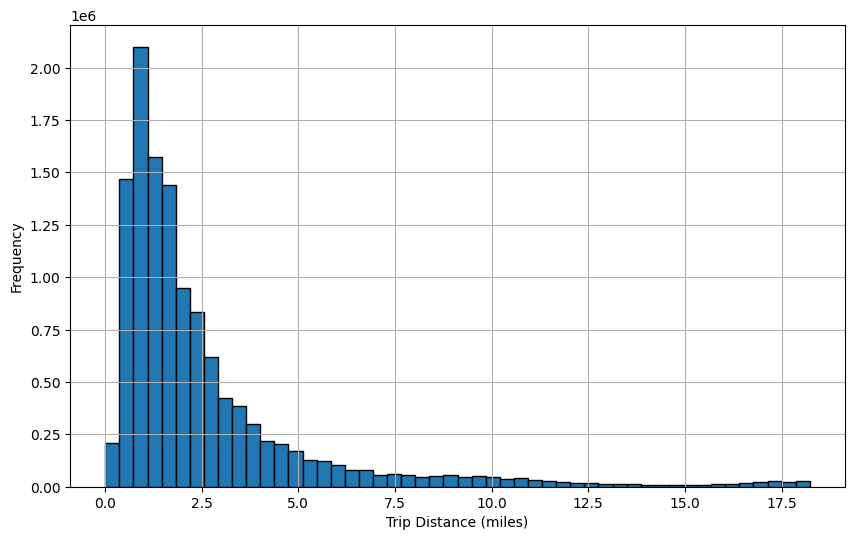

After removing outliers: 12300025


In [7]:
q_high = clean_taxi["trip_distance"].quantile(0.99)
filtered_taxi = clean_taxi[clean_taxi["trip_distance"] < q_high].copy()

plt.figure(figsize=(10, 6))
plt.hist(filtered_taxi["trip_distance"], bins=50, edgecolor='black')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
print(f"After removing outliers: {len(filtered_taxi)}")

In [8]:
print(q_high)

del clean_taxi  # free up memory

gc.collect()

18.24


6134

In [9]:
print("Latitude range:", filtered_taxi["pickup_latitude"].min(), filtered_taxi["pickup_latitude"].max())
print("Logitude range:", filtered_taxi["dropoff_longitude"].min(), filtered_taxi["dropoff_longitude"].max())

Latitude range: 40.04163360595703 41.49359130859375
Logitude range: -74.8927230834961 -72.44942474365233


In [10]:
filtered_taxi[["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,1.230002e+07,1.230002e+07,1.230002e+07,1.230002e+07
mean,4.075182e+01,-7.397603e+01,4.075208e+01,-7.397469e+01
std,2.564582e-02,3.202561e-02,3.005829e-02,3.151097e-02
min,4.004163e+01,-7.499691e+01,4.003058e+01,-7.489272e+01
25%,4.073764e+01,-7.399194e+01,4.073632e+01,-7.399134e+01
50%,4.075425e+01,-7.398205e+01,4.075446e+01,-7.398025e+01
75%,4.076807e+01,-7.396834e+01,4.076923e+01,-7.396416e+01
max,4.149359e+01,-7.244942e+01,4.141386e+01,-7.244942e+01


In [11]:
filtered_taxi["passenger_count"].value_counts()

,count
passenger_count,
1,8661668
2,1751641
5,683552
3,512219
6,445597
4,245335
7,6
9,4
8,3


In [12]:
filtered_taxi["dropoff_datetime"] = pd.to_datetime(filtered_taxi["tpep_dropoff_datetime"])
filtered_taxi["pickup_datetime"] = pd.to_datetime(filtered_taxi["tpep_pickup_datetime"])

duration = (filtered_taxi["dropoff_datetime"] - filtered_taxi["pickup_datetime"]).dt.total_seconds() / 60
print(filtered_taxi[duration < 1].size,filtered_taxi[duration > 120].size)

693567 216636


In [13]:
print(len(filtered_taxi[duration < 1]),len(filtered_taxi[duration > 120]))

33027 10316


In [14]:
f2_taxi = filtered_taxi[(duration > 1) & (duration < 120)].copy()
duration = (f2_taxi["dropoff_datetime"] - f2_taxi["pickup_datetime"]).dt.total_seconds() / 60 # recompute so that the incides align
print(f"Rows: {len(f2_taxi)}")  # or f2_taxi.shape[0]
print(f"Total elements: {f2_taxi.size}")  # rows × columns

Rows: 12255457
Total elements: 257364597


In [15]:
print(len(f2_taxi))
del filtered_taxi
gc.collect()

12255457


17

In [16]:
f2_taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,dropoff_datetime,pickup_datetime
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,...,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05,2015-01-15 19:23:42,2015-01-15 19:05:39
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,...,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80,2015-01-10 20:53:28,2015-01-10 20:33:38
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,...,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80,2015-01-10 20:43:41,2015-01-10 20:33:38
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,...,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,2015-01-10 20:35:31,2015-01-10 20:33:39
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,...,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30,2015-01-10 20:52:58,2015-01-10 20:33:39


In [17]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 3959  # Earth radius in miles
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.atan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

In [18]:
f2_taxi["fare_per_mile"] = f2_taxi["fare_amount"] / f2_taxi['trip_distance']
f2_taxi["geo_distance"] = haversine(
    f2_taxi["pickup_latitude"],
    f2_taxi["pickup_longitude"],
    f2_taxi["dropoff_latitude"],
    f2_taxi["dropoff_longitude"]
)
f2_taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,dropoff_datetime,pickup_datetime,fare_per_mile,geo_distance
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,...,1.0,0.5,3.25,0.0,0.3,17.05,2015-01-15 19:23:42,2015-01-15 19:05:39,7.547170,1.001024
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,...,0.5,0.5,2.00,0.0,0.3,17.80,2015-01-10 20:53:28,2015-01-10 20:33:38,4.393939,2.438754
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,...,0.5,0.5,0.00,0.0,0.3,10.80,2015-01-10 20:43:41,2015-01-10 20:33:38,5.277778,1.611153
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,...,0.5,0.5,0.00,0.0,0.3,4.80,2015-01-10 20:35:31,2015-01-10 20:33:39,7.000000,0.493789
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,...,0.5,0.5,0.00,0.0,0.3,16.30,2015-01-10 20:52:58,2015-01-10 20:33:39,5.000000,2.202665


In [19]:
f2_taxi["hour"] = f2_taxi["pickup_datetime"].dt.hour
f2_taxi["day_of_week"] = f2_taxi["pickup_datetime"].dt.dayofweek
f2_taxi["is_weekend"] = f2_taxi["day_of_week"].isin([5, 6])
f2_taxi["is_rush_hour"] = f2_taxi["hour"].between(7, 9) | f2_taxi["hour"].between(16, 18)
f2_taxi["morning_rush"] = f2_taxi["hour"].between(7, 9)
f2_taxi["evening_rush"] = f2_taxi["hour"].between(16, 18)
f2_taxi["speed_mph"] = f2_taxi["trip_distance"] / (duration / 60)
f2_taxi["route_efficiency"] = np.where(
    f2_taxi["geo_distance"] > 0,
    f2_taxi["trip_distance"] / f2_taxi["geo_distance"],
    np.nan
)
f2_taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,fare_per_mile,geo_distance,hour,day_of_week,is_weekend,is_rush_hour,morning_rush,evening_rush,speed_mph,route_efficiency
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,...,7.547170,1.001024,19,3,False,False,False,False,5.285319,1.588373
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,...,4.393939,2.438754,20,5,True,False,False,False,9.983193,1.353150
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,...,5.277778,1.611153,20,5,True,False,False,False,10.746269,1.117212
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,...,7.000000,0.493789,20,5,True,False,False,False,16.071429,1.012578
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,...,5.000000,2.202665,20,5,True,False,False,False,9.318378,1.361987


In [20]:
print(len(f2_taxi[f2_taxi['route_efficiency'] > 20]))
f2_taxi[f2_taxi['route_efficiency'] > 20].head()


23109


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,fare_per_mile,geo_distance,hour,day_of_week,is_weekend,is_rush_hour,morning_rush,evening_rush,speed_mph,route_efficiency
231,1,2015-01-20 23:08:13,2015-01-20 23:14:04,1,1.20,-74.008102,40.712421,1,N,-74.007866,...,5.416667,0.012399,23,1,False,False,False,False,12.307692,96.785099
799,1,2015-01-10 20:33:36,2015-01-10 20:52:50,1,3.20,-74.002548,40.734013,1,N,-74.004326,...,4.843750,0.135578,20,5,True,False,False,False,9.982669,23.602634
1905,1,2015-01-23 18:09:39,2015-01-23 18:34:52,1,4.00,-73.954872,40.789082,1,N,-73.954262,...,4.500000,0.073463,18,4,False,True,False,True,9.517515,54.449500
2187,2,2015-01-10 21:34:49,2015-01-10 21:57:37,2,2.53,-73.883133,40.744686,1,N,-73.883987,...,5.928854,0.051524,21,5,True,False,False,False,6.657895,49.103319
2337,1,2015-01-10 22:14:50,2015-01-10 22:31:17,1,2.10,-73.984093,40.760674,1,N,-73.984489,...,5.714286,0.023531,22,5,True,False,False,False,7.659574,89.245231


In [21]:
f2_taxi[f2_taxi["trip_distance"] < 0.1]["fare_per_mile"].describe()

,fare_per_mile
count,4305.000000
mean,226.393905
std,765.443901
min,27.777778
25%,50.000000
50%,75.000000
75%,166.666667
max,27500.000000


In [22]:
print((f2_taxi["trip_distance"] > 0.1)[:5], (f2_taxi['route_efficiency'] < 20)[:5])
print(len(f2_taxi["trip_distance"] > 0.1), len(f2_taxi['route_efficiency'] < 20))

0    True
1    True
2    True
3    True
4    True
Name: trip_distance, dtype: bool 0    True
1    True
2    True
3    True
4    True
Name: route_efficiency, dtype: bool
12255457 12255457


In [23]:
f3_taxi = f2_taxi[
    (f2_taxi["trip_distance"] > 0.1) &
    (f2_taxi['route_efficiency'] < 20)
]
print(len(f3_taxi))
f3_taxi.head()

12163916


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,fare_per_mile,geo_distance,hour,day_of_week,is_weekend,is_rush_hour,morning_rush,evening_rush,speed_mph,route_efficiency
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,...,7.547170,1.001024,19,3,False,False,False,False,5.285319,1.588373
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,...,4.393939,2.438754,20,5,True,False,False,False,9.983193,1.353150
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,...,5.277778,1.611153,20,5,True,False,False,False,10.746269,1.117212
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,...,7.000000,0.493789,20,5,True,False,False,False,16.071429,1.012578
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,...,5.000000,2.202665,20,5,True,False,False,False,9.318378,1.361987


In [24]:
del f2_taxi
gc.collect()

15

In [25]:
taxi_batch = f3_taxi.sample(10000)

## 3. Preprocess the Dataset

Clean and preprocess the dataset, e.g., handle missing values, engineer new features, perform discretization, etc. You may approach this task in an iterative manner, i.e., you may implement a first version and then back to it later, if needed.

### Classification task

There is no predefined classification task for this dataset. You should define your own. Prepare your solution introducing some problem parameters so that they can be easily changed in the future. For example:

- You may want to predict whether the tip amount will be above a certain threshold `LARGE_TIP_THRESHOLD` (e.g., above 20% of the total amount or total amount with tip excluded) - investigate the distribution of the target variable with respect to different values of `LARGE_TIP_THRESHOLD`, plot it, and choose a reasonable value. A hint: the tip amount is reported only for cashless payments, so you may want to first filter the dataset to include only such records.
- You may want to predict whether the total amount will be above a certain threshold `HIGH_TOTAL_AMOUNT_THRESHOLD` - what is a reasonable value for this threshold?
- etc.

What evaluation approach will you use? How will you split the dataset into training and test sets?

In [26]:
taxi_batch_geo = taxi_batch[["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "pickup_datetime", "dropoff_datetime", "is_weekend", "is_rush_hour", "morning_rush", "evening_rush"]].copy()
# Manhattan business district: 40.74-40.76, lon -73.98 to -74.00
taxi_batch_geo["from_business_district"] = taxi_batch_geo["pickup_latitude"].between(40.74, 40.76) & taxi_batch_geo["pickup_longitude"].between(-74.00, -73.98)
taxi_batch_geo["to_business_district"] = taxi_batch_geo["dropoff_latitude"].between(40.74, 40.76) & taxi_batch_geo["dropoff_longitude"].between(-74.00, -73.98)

# dropoff close to midpoint than pickup
midpoint = ((40.75 + 40.74) / 2, (-74.00 + -73.98) / 2)
taxi_batch_geo["headed_downtown"] = np.linalg.norm(taxi_batch_geo[["pickup_latitude", "pickup_longitude"]] - midpoint, axis=1) < np.linalg.norm(taxi_batch_geo[["dropoff_latitude", "dropoff_longitude"]] - midpoint, axis=1)
taxi_batch_geo.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_datetime,dropoff_datetime,is_weekend,is_rush_hour,morning_rush,evening_rush,from_business_district,to_business_district,headed_downtown
3693286,40.750198,-73.979309,40.739681,-73.992004,2015-01-04 15:48:44,2015-01-04 15:54:03,True,False,False,False,False,False,False
7392345,40.798264,-73.936981,40.786423,-73.945618,2015-01-22 02:25:22,2015-01-22 02:27:30,False,False,False,False,False,False,False
9959511,40.712830,-74.013962,40.774311,-73.980560,2015-01-30 17:30:30,2015-01-30 17:55:01,False,True,False,True,False,False,False
3085708,40.743950,-73.999527,40.735180,-74.008499,2015-01-11 20:37:41,2015-01-11 20:41:27,True,False,False,False,True,False,True
9771591,40.762501,-73.985588,40.739239,-73.993752,2015-01-10 18:10:22,2015-01-10 18:19:45,True,True,False,True,False,False,False


## 4. Implement Different Techniques for Handling Large Datasets

### Classification Model

Implement a simple Naive Bayes classifier on your own that can be applied to large datasets - it should be able to process the dataset in parts, e.g., by processing one column or batch of rows at a time. Alternatively, you can use different model from available libraries, as long as it can be applied to large datasets. Be creative!

### Techniques for Handling Large Datasets

You can incorporate the following techniques for handling large datasets directly in your solution, or you can split the process into two steps - first, preprocess the data and save it (use `parquet` format), then use the saved file to train and evaluate the model. Prepare your solution so that you can easily change the parameters of the techniques you use and compare the results, computation time and the size of the processed data used for training the model.

- Process the full dataset in parts - process the dataset in parts, e.g., by processing one column at a time for Naive Bayes (compute the necessary distributions for each column) or by processing batches of rows and creating an ensemble of models.
- Sampling techniques - sample a subset of the dataset, e.g., using random sampling, stratified sampling, - introduce a parameter `FRAC` that defines the fraction of the dataset to be sampled.
- Summarization techniques - apply clustering/gridding/binning to group similar instances and aggregate the values within each cluster/bin. E.g., you can use location-related features (pickup and dropoff coordinates) to create bins and aggregate (you can take the mean for numerical features and the majority value "*mode*" for categorical features) the rides which have pickup and dropoff locations within the same bin.
- Quantization techniques - reduce the number of distinct values for numerical features, e.g., by applying rounding, flooring, ceiling, or other techniques. Store values with reduced precision - it can reduce I/O time and memory usage and consequently speed up the computations.


2. Preprocess the Dataset

Clean and preprocess the dataset, e.g., handle missing values, engineer new features (e.g., a day of the week from time-related columns), perform discretization if needed, etc. You may approach this task in an iterative manner, i.e., you may implement a first version and then back to it later. You can reuse some of the code from the previous lab.
Clustering task

Prepare a solution for a clustering task. Wherever possible, introduce hyperparameters so that you can easily obtain results for different settings.

What evaluation approach will you use to compare the clustering results?



3. Implement Different Techniques for Handling Large Datasets
Clustering task

Implement an algorithm from the family of k-means, k-medoids, or k-prototypes, depending on the types of features you have engineered. Remember that the data should be properly preprocessed before applying an algorithm of your choice, e.g., what is the risk of using k-means on features with very different scales? Use hyperparameters such as the number of clusters k, the distance measure, the maximum number of iterations, etc.
Techniques for Handling Large Datasets

Use the same techniques for handling large datasets as in the previous lab:

    Process the full dataset in parts - process the dataset in parts, e.g., by processing one column at a time for Naive Bayes (compute the necessary distributions for each column) or by processing batches of rows and creating an ensemble of models.
    Sampling techniques - sample a subset of the dataset, e.g., using random sampling, stratified sampling, - introduce a parameter FRAC that defines the fraction of the dataset to be sampled.
    Summarization techniques - apply clustering/gridding/binning to group similar instances and aggregate the values within each cluster/bin. E.g., you can use location-related features (pickup and dropoff coordinates) to create bins and aggregate (you can take the mean for numerical features and the majority value "mode" for categorical features) the rides which have pickup and dropoff locations within the same bin.
    Quantization techniques - reduce the number of distinct values for numerical features, e.g., by applying rounding, flooring, ceiling, or other techniques. Store values with reduced precision - it can reduce I/O time and memory usage and consequently speed up the computations.



In [31]:
taxi_geo_x = taxi_batch_geo[["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "is_weekend"]]
taxi_geo_x.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,is_weekend
3693286,40.750198,-73.979309,40.739681,-73.992004,True
7392345,40.798264,-73.936981,40.786423,-73.945618,False
9959511,40.712830,-74.013962,40.774311,-73.980560,False
3085708,40.743950,-73.999527,40.735180,-74.008499,True
9771591,40.762501,-73.985588,40.739239,-73.993752,True


In [34]:
taxi_geo_y = taxi_batch_geo.apply(
    lambda x: 0 if x["morning_rush"] else 1 if x["evening_rush"] else 2,
    axis=1
)
taxi_geo_y.head()

,0
3693286,2
7392345,2
9959511,1
3085708,2
9771591,1


In [36]:
print(np.sum(taxi_geo_y == 0), np.sum(taxi_geo_y == 1), np.sum(taxi_geo_y == 2))

1279 1568 7153


In [29]:
# Normalize
taxi_geo_x_means = taxi_geo_x.mean()
taxi_geo_x_stds = taxi_geo_x.std()
taxi_geo_x_normalized = (taxi_geo_x - taxi_geo_x_means) / taxi_geo_x_stds
taxi_geo_x_normalized.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,is_weekend
3693286,-0.055795,-0.107149,-0.409353,-0.556840,1.481786
7392345,1.792512,1.183678,1.140068,0.906069,-0.674794
9959511,-1.492780,-1.163915,0.738581,-0.195925,-0.674794
3085708,-0.296075,-0.723712,-0.558567,-1.077039,1.481786
9771591,0.417284,-0.298632,-0.424022,-0.611940,1.481786


In [30]:
taxi_geo_x_normalized.describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,is_weekend
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,-6.855601e-14,2.509690e-13,-1.204079e-13,6.897469e-14,6.394885e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.196427e+00,-1.918216e+00,-6.012330e+00,-6.619733e+00,-6.747938e-01
25%,-5.560110e-01,-4.959907e-01,-5.115898e-01,-5.330798e-01,-6.747938e-01
50%,9.705737e-02,-1.896287e-01,8.747820e-02,-1.740294e-01,-6.747938e-01
75%,6.376137e-01,2.289362e-01,5.585764e-01,3.322142e-01,1.481786e+00
max,6.058580e+00,1.683624e+01,5.169345e+00,1.739556e+01,1.481786e+00


In [43]:
def k_means(x, n_clusters=3, max_iter=100):
    centers = x.sample(n_clusters).values
    print("Centers:", centers)

    for _ in range(max_iter):
        distances = np.sqrt(((x.values - centers[:, np.newaxis])**2).sum(axis=2))
        #print("Distances:", distances)
        labels = np.argmin(distances, axis=0)
        #print("Labels:", labels)

        new_centers = np.array([x.values[labels == i].mean(axis=0) for i in range(n_clusters)])

        # compute the average between all values

        if np.allclose(centers, new_centers):
            break

        centers = new_centers

    return labels, centers

init_labels, init_centers = k_means(taxi_geo_x_normalized, n_clusters=3, max_iter=1)
print("Initial cluster sizes:", np.sum(init_labels == 0), np.sum(init_labels == 1), np.sum(init_labels == 2))
print("Initial average distance:", np.mean(np.sqrt(((taxi_geo_x_normalized.values - init_centers[:, np.newaxis])**2).sum(axis=2))))

labels, centers = k_means(taxi_geo_x_normalized, n_clusters=3)
print("Cluster sizes:", np.sum(labels == 0), np.sum(labels == 1), np.sum(labels == 2))
print("average distance:", np.mean(np.sqrt(((taxi_geo_x_normalized.values - centers[:, np.newaxis])**2).sum(axis=2))))

Centers: [[-0.89882784 -0.27629653 -0.2509083  -0.57560762 -0.67479381]
 [ 0.14458525 -0.43148428 -0.04567613 -0.13914095 -0.67479381]
 [-0.00885354 -0.56038086  0.31117241 -0.06094268 -0.67479381]]
Initial cluster sizes: 2952 3924 3124
Initial average distance: 2.1725072562774157
Centers: [[ 0.12991615  0.15413427  0.40575877  0.3447259   1.48178596]
 [-0.43147031 -0.98080705 -1.01341599 -0.64755003 -0.67479381]
 [-1.43601028 -0.82096599  0.72353353 -0.12326069 -0.67479381]]
Cluster sizes: 2907 4000 3093
average distance: 2.2668928340521437


In [45]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(taxi_geo_y, labels)
nmi = normalized_mutual_info_score(taxi_geo_y, labels)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

Adjusted Rand Index (ARI): -0.00018989226198092195
Normalized Mutual Information (NMI): 0.006191556165385


In [33]:
# # Find which cluster matches
# share_0 = np.sum(taxi_geo_y == (labels == 0))
# share_1 = np.sum(taxi_geo_y == (labels == 1))
# share_2 = np.sum(taxi_geo_y == (labels == 2))
# print("Cluster agreement:", max(share_0, share_1, share_2) / len(labels))

Cluster agreement: 0.8303249097472925


In [46]:
import umap

In [47]:
import numpy as np
import pandas as pd

def k_medoids(x, n_clusters=2, max_iter=100):
    x_np = x.values if isinstance(x, pd.DataFrame) else x

    # Ensure unique initial medoids
    medoid_indices = np.random.choice(len(x_np), n_clusters, replace=False)
    medoids = x_np[medoid_indices]

    for iteration in range(max_iter):
        # calculate distances from each point to each medoid
        # x_np: (n_samples, n_features)
        # medoids: (n_clusters, n_features)
        # distance: (n_samples, n_clusters)
        distances = np.sqrt(((x_np[:, np.newaxis, :] - medoids[np.newaxis, :, :])**2).sum(axis=2))

        # choose closest
        labels = np.argmin(distances, axis=1)

        # find new medoids
        new_medoids = np.empty_like(medoids)
        for i in range(n_clusters):
            cluster_points = x_np[labels == i]
            if len(cluster_points) == 0:
                # If a cluster becomes empty, keep the old medoid or reinitialize it randomly
                # This can happen if a medoid is an outlier
                new_medoids[i] = medoids[i]
                continue

            min_cost = np.inf
            best_medoid_candidate = None

            for p_candidate in cluster_points:
                # Calculate distances from p_candidate to all other points in the cluster
                cost = np.sum(np.sqrt(((cluster_points - p_candidate)**2).sum(axis=1)))
                if cost < min_cost:
                    min_cost = cost
                    best_medoid_candidate = p_candidate
            new_medoids[i] = best_medoid_candidate

        # convergence Check
        if np.allclose(medoids, new_medoids):
            print(f"K-Medoids converged after {iteration + 1} iterations.")
            break
        medoids = new_medoids

    final_distances = np.sqrt(((x_np[:, np.newaxis, :] - medoids[np.newaxis, :, :])**2).sum(axis=2))
    final_labels = np.argmin(final_distances, axis=1)

    return final_labels, medoids

print("Initial run with max_iter=1 (one iteration):")
init_labels_medoids, init_medoids = k_medoids(taxi_geo_x_normalized, n_clusters=3, max_iter=1)
print("Initial Medoids:\n", init_medoids)
print(f"Cluster 0 size: {np.sum(init_labels_medoids == 0)}, Cluster 1 size: {np.sum(init_labels_medoids == 1)}")

init_distances_to_medoids = np.min(np.sqrt(((taxi_geo_x_normalized.values[:, np.newaxis, :] - init_medoids[np.newaxis, :, :])**2).sum(axis=2)), axis=1)
print("Average distance to medoids (initial state):", np.mean(init_distances_to_medoids))

print("\nRunning K-Medoids for full convergence:")
labels_medoids, medoids = k_medoids(taxi_geo_x_normalized, n_clusters=3)
print("Final Medoids:\n", medoids)
print(f"Cluster 0 size: {np.sum(labels_medoids == 0)}, Cluster 1 size: {np.sum(labels_medoids == 1)}")

final_distances_to_medoids = np.min(np.sqrt(((taxi_geo_x_normalized.values[:, np.newaxis, :] - medoids[np.newaxis, :, :])**2).sum(axis=2)), axis=1)
print("Average distance to medoids (final state):", np.mean(final_distances_to_medoids))

Initial run with max_iter=1 (one iteration):
Initial Medoids:
 [[-4.13879197  5.65899517 -1.16427365  0.80020076 -0.67479381]
 [-0.44745963 -0.44939951 -0.64543965 -0.68965679 -0.67479381]
 [ 0.28188803  0.03640563  0.47935404  0.1633059  -0.67479381]]
Cluster 0 size: 143, Cluster 1 size: 4182
Average distance to medoids (initial state): 1.6355817424736343

Running K-Medoids for full convergence:
K-Medoids converged after 8 iterations.
Final Medoids:
 [[-0.03188402 -0.14716729 -0.08386474 -0.0972748   1.48178596]
 [-0.33450756 -0.41007908 -0.41972219 -0.49019104 -0.67479381]
 [ 0.54299801  0.23789377  0.50831163  0.23548892 -0.67479381]]
Cluster 0 size: 3083, Cluster 1 size: 3422
Average distance to medoids (final state): 1.3597946561905847


In [50]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari_medoids = adjusted_rand_score(taxi_geo_y, labels_medoids)
nmi_medoids = normalized_mutual_info_score(taxi_geo_y, labels_medoids)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

Adjusted Rand Index (ARI): -0.00018989226198092195
Normalized Mutual Information (NMI): 0.006191556165385


In [48]:
import umap

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


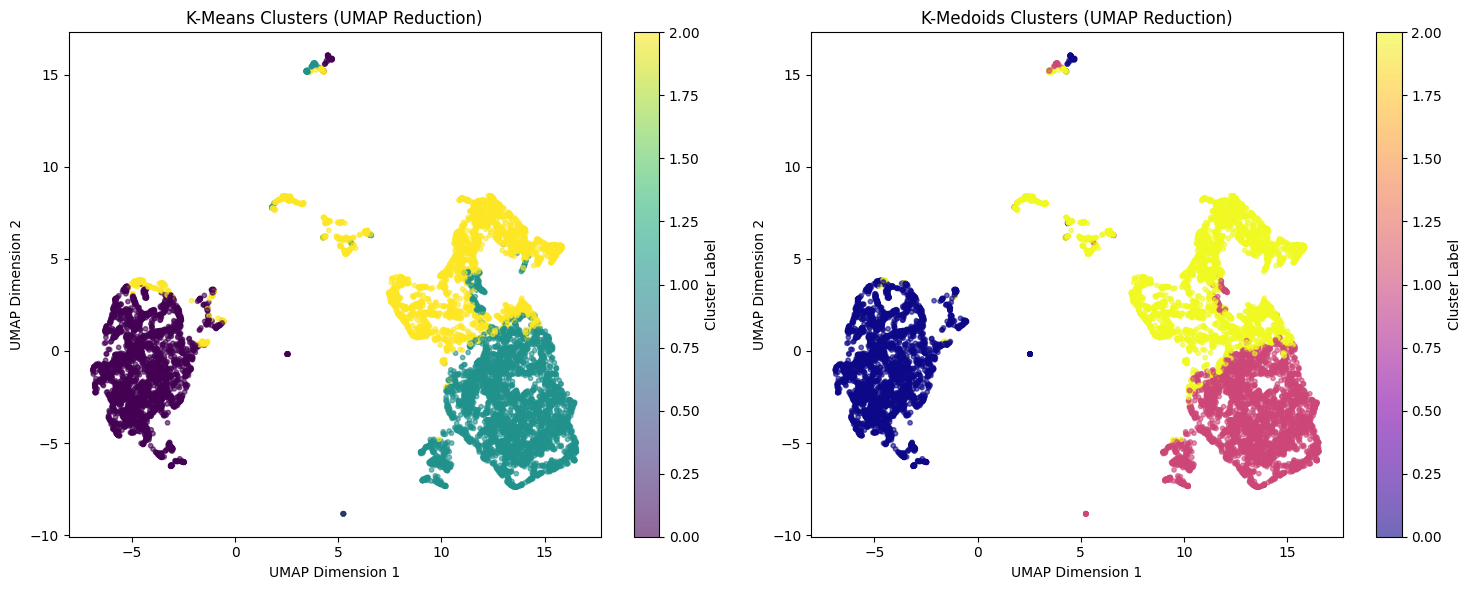

In [49]:
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_k_means = reducer.fit_transform(taxi_geo_x_normalized)
embedding_k_medoids = reducer.fit_transform(taxi_geo_x_normalized)

plt.figure(figsize=(15, 6))

# K-Means visualization
plt.subplot(1, 2, 1)
plt.scatter(embedding_k_means[:, 0], embedding_k_means[:, 1], c=labels, cmap='viridis', s=10, alpha=0.6)
plt.title('K-Means Clusters (UMAP Reduction)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cluster Label')

# K-Medoids visualization
plt.subplot(1, 2, 2)
plt.scatter(embedding_k_medoids[:, 0], embedding_k_medoids[:, 1], c=labels_medoids, cmap='plasma', s=10, alpha=0.6)
plt.title('K-Medoids Clusters (UMAP Reduction)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cluster Label')

plt.tight_layout()
plt.show()